In [20]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

(720, 1280, 3)


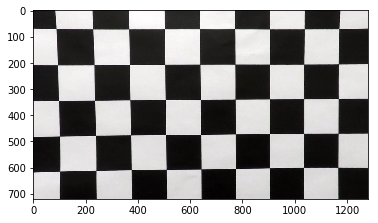

In [21]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)  
objpoints, imgpoints=[],[]
images = glob.glob('camera_cal/calibration*.jpg')


for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    
    if ret==True:
    
        objpoints.append(objp)
        imgpoints.append(corners)

   
ret, mtx, dist, rvecs, tvecs= cv2.calibrateCamera(objpoints, imgpoints, gray.shape[: :-1], None, None)
        
       

img =mpimg.imread('camera_cal/calibration1.jpg')
undist=cv2.undistort(img, mtx, dist, None, mtx)

print(img.shape)       
cv2.imwrite('output_images/undistorted_calibration1.png', undist)       
plt.imshow(undist)
plt.show()        


In [22]:
def abs_sobel_threshold(img,  kernel=3, sobel_thresh=(0,255)):
     gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                #convert to grayscale
     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)                #sobel in x direction
     abs_sobel=np.absolute(sobelx)
    
     scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
     
     sbinary = np.zeros_like(scaled_sobel)
     sbinary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <=sobel_thresh[1])] = 1
     
     
     return sbinary
    
     
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag=np.sqrt(sobelx**2 + sobely**2)           
    scale_factor = np.max(mag)/255 
    mag = (mag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(mag)
    
    binary_output[(mag >= mag_thresh[0]) & (mag <= mag_thresh[1])] = 1
    
    return binary_output

def direction_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    direction=np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    
    return binary_output

def hls_select(img, thresh=(0, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
   
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output





In [23]:
def binary(image):
    dir_binary=direction_thresh(image, sobel_kernel=17, thresh=(0.7,5))
    #plt.imshow(dir_binary)
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(100, 200))
    
    grad_binary = abs_sobel_threshold(image,kernel=25, sobel_thresh=(30,50))
    #print(grad_binary.shape)
    combined_grad = np.zeros_like(dir_binary)
    #print(dir_binary.shape)
    combined_grad[((grad_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    color_thresh=hls_select(image, thresh=(90,150))
    color_binary=np.dstack((np.zeros_like(combined_grad), combined_grad, color_thresh))*255
    final=np.zeros_like(combined_grad)
    final[(combined_grad==1) | (color_thresh==1)]=1
    
    return final




In [29]:
src=np.float32([[220, 720], [1110,720], [570,470], [722, 470]])
dst=np.float32([[320, 720], [920, 720], [320, 1], [920, 1]])
M = cv2.getPerspectiveTransform(src, dst)
M_inv=cv2.getPerspectiveTransform(dst, src)


def warped(img):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    frame_normed = 255 * (warped - warped.min()) / (warped.max() - warped.min())
    frame_normed = np.array(frame_normed, np.int)
    return warped

img=mpimg.imread('test_images/test1.jpg')
b=binary(img)
pers=warped(b)

In [25]:
def histogram(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    return histogram

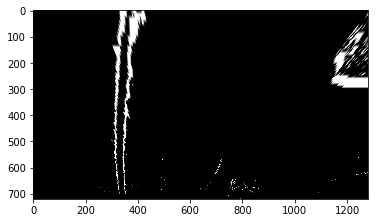

In [30]:
def findlanelines(img):
    hist=histogram(img)

    midpoint = np.int(hist.shape[0]//2)
#left and right side peaks
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    oue = np.dstack((img, img, img))

    nwindows=9
    margin=100
    minpix=50
    
    window_height = np.int(img.shape[0]//nwindows)
    nonzero = img.nonzero() #nonzero indices of the image
    nonzeroy = np.array(nonzero[0])# nonzero y indices of the image
    nonzerox = np.array(nonzero[1])# nonzero x indices of the image

    leftx_current = leftx_base                #initialize the left lane pixel
    rightx_current = rightx_base              #initialize the right lane pixel


    left_lane_inds = []
    right_lane_inds = []
     
    for window in range(nwindows):
    
      win_y_low = img.shape[0] - (window+1)*window_height
      win_y_high = img.shape[0] - window*window_height
      win_xleft_low = leftx_current - margin
      win_xleft_high = leftx_current + margin
      win_xright_low = rightx_current - margin
      win_xright_high = rightx_current + margin
        
      good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
      (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
      good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
      (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
      
    
      left_lane_inds.append(good_left_inds)
      right_lane_inds.append(good_right_inds)  
      if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
      if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
 
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
     
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
     
#leftx, lefty, rightx, righty, out = findpixels(img)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )  #generate y values from the fitted polynomial
    
    left_fit = np.polyfit(lefty, leftx, 2)  #POLYNOMIAL for left lane
    right_fit = np.polyfit(righty, rightx, 2) #polynomial for right lane
    left_fitx=ploty*left_fit[0]**2+ploty*left_fit[1]+left_fit[2]
    right_fitx=ploty*right_fit[0]**2+ploty*right_fit[1]+right_fit[2]
    
       
    oue[lefty, leftx] = [255, 0, 0]
    oue[righty, rightx] = [0, 0, 255]

 #   plt.imshow(oue)
  #  plt.plot(left_fitx, ploty, color='yellow')
   # plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, img.shape[1])
    #plt.ylim(img.shape[0],0)
    return oue
b=mpimg.imread('output_images/perspective_test1.png')
a=findlanelines(pers)
plt.imshow(a)
